In [326]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.io import fits
import os.path
from astropy.coordinates import Angle
from astropy import units as u
from scipy.stats import norm

<hr/>

**INSTRUCTION**
NOTE: This notebook composed of two sections: <br/>
    -Extracting RA and DEC, and Redshift <br/>
    -Plotting

**-Extracting RA and DEC, and Redshift** <br/>
1.Create a file titled "Redshift CSV" in the same workspace as this notebook. Your CSV file contining the RA, Dec, Redshift, and QOP will be stored here.<br/>
2.Below the "Saving DataFrame as CSV File" is the #BREAK. Run everything from there and above. <br/>
3.This will find the RA, Dec, Redshift, and QOP -> Find if there an existing CSV file to save them  -> If no, create the appropriate file to save it -> If yes, open it and add to it. <br/>
4.Change mask_name to a new file and run for all mask. <br/>

**-Plotting** <br/>
1."Plotting" and "Using Delta_RA and Delta_Dec" sections will produce your velocity map. Run these two sections after you have run all masks through the previous section. <br/>
2.Four plots will be produced. Two maps will be your velocity maps with Dec and RA. Two maps will be your velocity maps with Delta Dec and Delta RA. 

**-HI and CO Maps** <br/>
1.Required M33_2018b_phot_spec.txt to run <br/>
2.Run section to extract data, convert to deg, and plot. <br/>
<hr/>

## Variables Pannel

In [ ]:
mask_name = "E2M33R" #Input mask name

## Get Excluded and Includes Slit Numbers

In [ ]:
def get_exclusions():
    filepath = 'ISM_EM_LINES.txt'
    fp = open(filepath)
    all_data = []
    for line in (fp):
        mask_name = line.split(':')[0].split('_')[0]
        slit_number = line.split(':')[1].strip().split(" ")[0]
        if len(slit_number) == 2:
            slit_number = '0' + slit_number
        elif len(slit_number) == 1:
            slit_number = '00' + slit_number
        else:
            pass
        object_id = line.split(':')[1].strip().split()[1]
        data = {}
        data['mask_name'] = mask_name
        data['slit_number'] = slit_number
        data['object_id'] = object_id
        all_data.append(data)
    return all_data     

In [ ]:
def get_files_to_include(folder):
    import os
    list_of_files_to_include = []
    list_of_files_to_exclude = []
    serendip_files = []
    all_file_names_in_folder = os.listdir('data/{}'.format(folder))
    y = len(all_file_names_in_folder)
    print("The number of files in the folder is {0}".format(y))
    all_data = get_exclusions()
    len_all_data = len(all_data)
    for n in range(y):
        parts_of_file_name = all_file_names_in_folder[n].split(".")
        if parts_of_file_name[0] == 'spec1d': # avoids hidden DS_Store files on my mac
            object_id = parts_of_file_name[3]
            slit_number = parts_of_file_name[2]
            mask_name = parts_of_file_name[1]
            should_include = True
            should_exclude = True
            for k in range(len_all_data):
                if ((object_id == all_data[k]['object_id']) and (slit_number == all_data[k]['slit_number']) and (mask_name == all_data[k]['mask_name'])):
                    should_include = False
                    should_exclude = True
                if 'serendip' in object_id:
                    should_include = False
                    should_exclude = False
            if should_include == True:
                list_of_files_to_include.append(all_file_names_in_folder[n])       
            elif should_exclude == True:
                list_of_files_to_exclude.append(all_file_names_in_folder[n])
            elif should_include == False & should_exclude == False:
                serendip_files.append(all_file_names_in_folder[n])
    
    print('The number of files left after exclusions is {0}'.format(len(list_of_files_to_include)))
    
    return sorted(list_of_files_to_include), sorted(list_of_files_to_exclude), sorted(serendip_files)


In [ ]:
def get_slit_nums(files):
    
    slit_nums = []
    
    if len(files) > 1:
    
        for i in range(len(files)):
            parts_of_file_name = files[i].split(".")
            slit_num = parts_of_file_name[2]
            slit_nums.append(int(slit_num))
            
    return slit_nums

In [ ]:
#filtering files
list_of_files_to_include, list_of_files_to_exclude, list_of_serendip_files = get_files_to_include(mask_name)

file_names = list_of_files_to_include #included
file_names_exclude = list_of_files_to_exclude #excluded
file_names_serendip = list_of_serendip_files #serendips

In [ ]:
slit_nums = get_slit_nums(file_names)
slit_nums_exclude = get_slit_nums(file_names_exclude)

print("Slit # to INCLUDE in median calculation: {0}".format(slit_nums))
print("Slit # to EXCLUDE: {0}".format(slit_nums_exclude))
print("Len of EXCL Slits: {0}".format(len(slit_nums_exclude)))

## Read RA, DEC, and Object ID

In [ ]:
def read_sky_coor(mask_name,list_of_excl_files,slit_nums_exclude):
    
    ra = [] #in deg
    dec = [] #in deg
    object_id = [] #object id
    
    for file in list_of_excl_files:
        #extracting RA and DEC from data files
        open_fits = fits.open("./data/{0}/{1}".format(mask_name,file))
        ra_obj = open_fits[1].header["RA_OBJ"].split(":") #[Hour,Min,Sec]
        dec_obj = open_fits[1].header["DEC_OBJ"].strip("+").split(":") #[Deg,Min,Sec]
        
        try: #save OBJID as int. If OBJID has letter, save as str
            obj_id = int(open_fits[1].header["OBJNO"])
        except:
            obj_id = open_fits[1].header["OBJNO"]
        
        #converting RA (HMS) to degrees format
        ra_obj_deg = (float(ra_obj[0]) + (float(ra_obj[1])/60) + (float(ra_obj[2])/3600)) * 15
        ra.append(ra_obj_deg)
        
        #converting Dec (DMS) to degrees format
        dec_obj_deg = (float(dec_obj[0]) + (float(dec_obj[1])/60) + (float(dec_obj[2])/3600))
        dec.append(dec_obj_deg)
    
        #add Object ID to list
        object_id.append(obj_id)
        
    #create DataFrame
    df = pd.DataFrame({"Mask Name":np.full(len(ra),mask_name),"Slit Number":slit_nums_exclude,
                       "RA":ra,"DEC":dec,"OBJECT ID":object_id})
    
    return df

In [ ]:
df = read_sky_coor(mask_name,file_names_exclude,slit_nums_exclude)

## Extract Redshift

In [ ]:
import numpy
def loadMarzResults(filepath):
    return numpy.genfromtxt(filepath, delimiter=',', skip_header=2, autostrip=True, names=True, dtype=None)

In [ ]:
#arrays containing all slits processed in MARZ
res = loadMarzResults("./Marz_Results (Redone)/{0}_Marz_KN.mz".format(mask_name)) 
confident = res[res['QOP'] == 4]

In [ ]:
redshift = {} #empty dict for redshift value
QOP = {} #empty dict for QOP

for n in range(len(res)): #sorting 
    redshift["Slit_{0}".format(slit_nums_exclude[n])] = res[n][12]*300000 #km/s
    QOP["Slit_{0}".format(slit_nums_exclude[n])] = res[n][13]

df["Velocity (km/s)"] = redshift.values() #adding column titled "Velocity" into DF
df["QOP"] = QOP.values() #adding column titled "QOP" into DF

## Saving DataFrame as a CSV file

In [ ]:
def savingdf_csv(df):
    if os.path.isfile("./Redshift CSV/Redshift.csv") == False: #isfile check if a file exist
        df.to_csv("./Redshift CSV/Redshift.csv",index=False)
    else:
        csv_to_df = pd.read_csv("./Redshift CSV/Redshift.csv")
        new_df = pd.concat([csv_to_df,df]) #concat add two DF together 
        new_df.to_csv("./Redshift CSV/Redshift.csv",index=False) #put index_column = False so that 
        #the overwritten csv file don't have extra column called "unnamed"

In [ ]:
savingdf_csv(df)

In [ ]:
#BREAK

In [ ]:
#BREAK

In [ ]:
#BREAK

## Plotting

In [148]:
df1 = pd.read_csv("./Redshift CSV/Redshift.csv")
df1_qop2_sorted = df1["QOP"] >= 2 #use only values that has a QOP of >= 2
df1_qop3_sorted = df1["QOP"] == 3 #use only values that has a QOP of 3

In [ ]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("M33 Velocity Color Map (QOP >= 2)")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(df1["RA"][df1_qop2_sorted]
                    ,df1["DEC"][df1_qop2_sorted]
                    ,c=df1["Redshift"][df1_qop2_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map (QOP >= 2)")

In [ ]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("M33 Velocity Color Map (QOP == 3)")
ax.set_aspect(1/0.861)
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
cc_map = ax.scatter(df1["RA"][df1_qop3_sorted]
                    ,df1["DEC"][df1_qop3_sorted]
                    ,c=df1["Redshift"][df1_qop3_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map")

## Using Delta_RA and Delta_Dec

In [ ]:
#ra_m32 = 01:33:50.8966
#dec_m32 = +30:39:36.630
ra_m32 = (1 + (33/60) + (50.8966/3600))*15 #in deg
dec_m32 = (30 + (39/60) + (36.630/3600)) # in deg

In [ ]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Delta RA (deg)")
ax.set_ylabel("Delta Dec (deg)")
ax.set_title("M33 Velocity Color Map (QOP >= 2)")
ax.invert_xaxis()
ax.set_aspect("equal")
cc_map = ax.scatter(((df1["RA"][df1_qop2_sorted]-ra_m32)*np.cos(dec_m32))
                    ,(df1["DEC"][df1_qop2_sorted]-dec_m32)
                    ,c=df1["Redshift"][df1_qop2_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map (QOP >= 2) w Del RA and Dec")

In [ ]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Delta RA (deg)")
ax.set_ylabel("Delta Dec (deg)")
ax.set_title("M33 Velocity Color Map (QOP == 3)")
ax.invert_xaxis()
ax.set_aspect("equal")
cc_map = ax.scatter(((df1["RA"][df1_qop3_sorted]-ra_m32)*np.cos(dec_m32))
                    ,(df1["DEC"][df1_qop3_sorted]-dec_m32)
                    ,c=df1["Redshift"][df1_qop3_sorted],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("Velocity Map w Del RA and Dec")

In [ ]:
#BREAK

In [ ]:
#BREAK

In [ ]:
#BREAK

## HI and CO Maps and Histograms

In [4]:
def read_M33_phot_spec():
    
    """
    Parameters
    ----------
    None
    
    Returns
    ----------
    RA: 1d-array containing RA in unit of deg.
    Dec: 1d-array containing Dec in unit of deg.
    maskname: list containing name of mask in M33_2018b_phot_spec.txt
    HI: 1d-array containing velocity measurements in HI region.
    CO: 1d-array containing velocity measurements in CO region.
    
    """
    
    RA = [] #Empty list to append RA
    Dec = [] #Empty list to append Dec
    maskname = [] #Empty list to append mask name
    HI = [] #Empty list to append v of HI region
    CO = [] #Empty list to append v of CO region
    OBJID = []
    
    M33_phot_spec_lines = open("M33_2018b_phot_spec.txt","r").readlines()
    for line in M33_phot_spec_lines[1:]: #[1:0] so that it does NOT read the labels
        RA.append(Angle(line.split()[1],u.hourangle).degree) #converting RA to Deg
        Dec.append(Angle(line.split()[2],u.deg).degree) #converting Dec to Deg
        maskname.append(line.split()[16]) #mask name of current line
        HI.append(float(line.split()[19])) #HI measurement of current line
        CO.append(float(line.split()[20])) #CO measurement of current line
        OBJID.append(line.split()[0]) #OBJID 
        
    return np.array(RA),np.array(Dec),maskname,np.array(HI),np.array(CO),OBJID
        

In [5]:
Ri_As,Decli,Maskname,HI,CO,OBJID = read_M33_phot_spec()

In [ ]:
HI_index = np.isnan(HI)==False #remove nan values from HI
CO_index = np.isnan(CO)==False #remove nan values from CO

### Plotting HI and CO Maps

In [ ]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("HI Region")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(Ri_As[HI_index],Decli[HI_index],c=HI[HI_index],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("HI Region")
plt.show()

In [ ]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("CO Region")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(Ri_As[CO_index],Decli[CO_index],c=CO[CO_index],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("CO Region")
plt.show()


### Determine # of Shared OBJ and Make Plots

In [409]:
def shared_obj(Maskname,OBJID):
    """
    Parameters
    ----------
    Maskname: list, req
        List containing mask names of all mask in M33_2018b_phot_spec.txt
    OBJID: list, req
        List containing Object ID of all objects in M33_2018b_phot_spec.txt
    
    Returns
    ----------
    Bool: List containing booleans of Redshift.csv objects in M33_2018b_phot_spec.txt
    Bool_Index: List containing indices of True values in Bool.
    csv_data: DataFrame containing content in Redshift.csv
    """
    csv_data = pd.read_csv("./Redshift CSV/Redshift.csv") #Read Redshift.csv and extract the Mask Namd and OBJID columns
    OBJID_myData = csv_data["OBJECT ID"]
    Maskname_myData = csv_data["Mask Name"]
    TupPairs_myData = list(zip(Maskname_myData,OBJID_myData)) #Create pairs of data
    TupPairs = list(zip(Maskname,OBJID)) #Create pairs of data from M33_2018b_phot_spec.txt
    Bool = [pair in TupPairs for pair in TupPairs_myData] #List of Bool checking whether objects in Redshift.csv is in M33_2018b_phot_spec.txt
    Bool_Index = [TupPairs.index(TupPairs_myData[index]) for index in range(len(Bool)) if Bool[index] == True]
    #Reverse_Bool = [pair in TupPairs_myData for pair in TupPairs] #List of Bool checking whether objects in M33_2018b_phot_spec.txt is in Redshift.csv
    
    return Bool,Bool_Index,csv_data

In [412]:
Bool,Bool_Index,csv_data = shared_obj(Maskname,OBJID)
myDataDF = pd.DataFrame({"Mask Name":csv_data["Mask Name"][np.where(np.array(Bool)==True)[0]],
                        "OBJID":csv_data["OBJECT ID"][np.where(np.array(Bool)==True)[0]],
                        "Velocity (km/s)":csv_data["Velocity (km/s)"][np.where(np.array(Bool)==True)[0]],
                        "Mask Name(Check)":np.array(Maskname)[np.array(Bool_Index)],
                        "OBJID(Check)":np.array(OBJID)[np.array(Bool_Index)],
                        "HI":HI[np.array(Bool_Index)],
                        "CO":CO[np.array(Bool_Index)],
                        "RA":Ri_As[np.array(Bool_Index)],
                        "Dec":Decli[np.array(Bool_Index)]}) #DF to stores relevant info
 
myDataDF.to_csv("./Redshift CSV/Redshift (incl. CO and HI).csv",index=False)
                        

In [413]:
myDataDF

,Mask Name,OBJID,Velocity (km/s),Mask Name(Check),OBJID(Check),HI,CO,RA,Dec
0,M33D2A,215883,-147.0,M33D2A,215883,-131.273229,NaN,23.484625,30.428111
1,M33D2A,238569,-138.0,M33D2A,238569,-133.932229,-123.597229,23.487375,30.453444
2,M33D2A,238675,-150.0,M33D2A,238675,-128.138736,NaN,23.478667,30.454750
3,M33D2A,245768,-138.0,M33D2A,245768,-141.122706,NaN,23.456917,30.461250
4,M33D2A,246366,-138.0,M33D2A,246366,-144.522544,NaN,23.493375,30.461306
5,M33D2A,247953,-138.0,M33D2A,247953,-150.151952,NaN,23.495708,30.463667
6,M33D2A,262694,-165.0,M33D2A,262694,-138.681686,NaN,23.506667,30.477000
7,M33D2A,265223,-147.0,M33D2A,265223,-133.901061,NaN,23.488167,30.480500
8,M33D2A,268109,-150.0,M33D2A,268109,-126.236657,-125.797657,23.297250,30.483972
9,M33D2A,272129,-150.0,M33D2A,272129,-132.845016,-128.063016,23.297250,30.489167


### Create Histograms of HAlpha-HI, HAlpha-CO, and HI-CO

In [414]:
V = np.array(myDataDF["Velocity (km/s)"]) #velocity calculated by me
HI_V = np.array(myDataDF["HI"]) #HI velocity from Amanda's data
CO_V = np.array(myDataDF["CO"]) #CO velocity from Amanda's data
VsubHI = V - HI_V #Halpha - HI
VsubCO = V - CO_V #Halpha - CO
HIsubCO = HI_V - CO_V #HI - CO

In [415]:
def normal_distribution(x,mu,sigma):
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp((-1/(2*(sigma**2)))*((x-mu)**2))

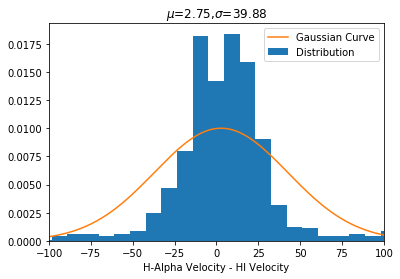

In [434]:
x = np.linspace(-250,250,1000)
mu, sigma = norm.fit(VsubHI[~np.isnan(VsubHI)]) #estimate mean and standard dev
f_x = normal_distribution(x,mu,sigma) #normal distribution formula
#p = norm.pdf(filler_data,mu,std)
Hist_info = plt.hist(VsubHI[~np.isnan(VsubHI)],bins=50,density=True,label="Distribution")
plt.plot(x,f_x,label="Gaussian Curve")
plt.title("$\mu$={0},$\sigma$={1}".format(round(mu,2),round(sigma,2)))
plt.xlabel("H-Alpha Velocity - HI Velocity")
plt.xlim(-100,100)
plt.legend()
plt.savefig("HAlpha-HI Histogram.png")

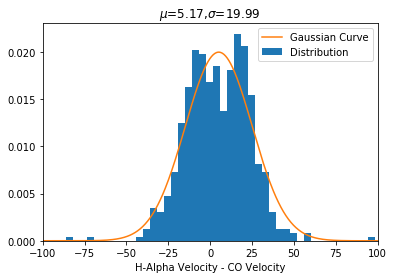

In [435]:
mu1, sigma1 = norm.fit(VsubCO[~np.isnan(VsubCO)])
f_x1 = normal_distribution(x,mu1,sigma1) #normal distribution formula
#p1 = norm.pdf(filler_data,mu1,std1)
Hist_info_1 = plt.hist(VsubCO[~np.isnan(VsubCO)],bins=50,density=True,label="Distribution")
plt.plot(x,f_x1,label="Gaussian Curve")
plt.title("$\mu$={0},$\sigma$={1}".format(round(mu1,2),round(sigma1,2)))
plt.xlabel("H-Alpha Velocity - CO Velocity")
plt.xlim(-100,100)
plt.legend()
plt.savefig("HAlpha-CO Histogram.png")

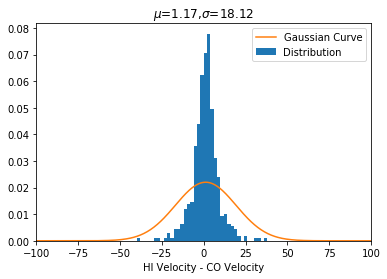

In [436]:
mu2, sigma2 = norm.fit(HIsubCO[~np.isnan(HIsubCO)])
f_x2 = normal_distribution(x,mu2,sigma2) #normal distribution formula
#p1 = norm.pdf(filler_data,mu1,std1)
Hist_info_2 = plt.hist(HIsubCO[~np.isnan(HIsubCO)],bins=50,range=(-50,50),density=True,label="Distribution")
plt.plot(x,f_x2,label="Gaussian Curve")
plt.title("$\mu$={0},$\sigma$={1}".format(round(mu2,2),round(sigma2,2)))
plt.xlabel("HI Velocity - CO Velocity")
plt.xlim(-100,100)
plt.legend()
plt.savefig("HI-CO Histogram.png")

### CC Map Using Subtraction Values

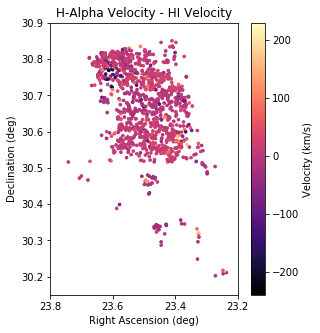

In [431]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("H-Alpha Velocity - HI Velocity")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(myDataDF["RA"][~np.isnan(VsubHI)]
                    ,myDataDF["Dec"][~np.isnan(VsubHI)]
                    ,c=VsubHI[~np.isnan(VsubHI)],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("H-Alpha - HI.png")

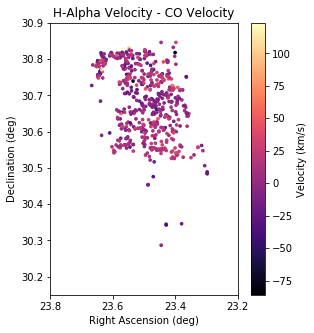

In [432]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("H-Alpha Velocity - CO Velocity")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(myDataDF["RA"][~np.isnan(VsubCO)]
                    ,myDataDF["Dec"][~np.isnan(VsubCO)]
                    ,c=VsubCO[~np.isnan(VsubCO)],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("H-Alpha - CO.png")

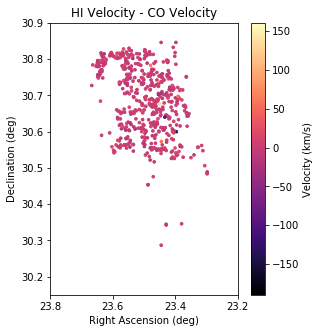

In [433]:
fig,ax = plt.subplots(1)
ax.set_xlabel("Right Ascension (deg)")
ax.set_ylabel("Declination (deg)")
ax.set_title("HI Velocity - CO Velocity")
ax.set_xlim(23.2,23.8)
ax.set_ylim(30.15,30.9)
ax.invert_xaxis()
ax.set_aspect(1/0.861)
cc_map = ax.scatter(myDataDF["RA"][~np.isnan(HIsubCO)]
                    ,myDataDF["Dec"][~np.isnan(HIsubCO)]
                    ,c=HIsubCO[~np.isnan(HIsubCO)],s=7,cmap='magma')
plt.colorbar(cc_map,label="Velocity (km/s)")
fig.set_figwidth(5)
fig.set_figheight(5)
plt.savefig("HI - CO.png")